# 0. Install and Import Dependencies

In [1]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4e7b2d58-4c80-4d74-8090-8710f062c7fe
To: c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\research\data.zip
100%|██████████| 423M/423M [00:11<00:00, 36.2MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

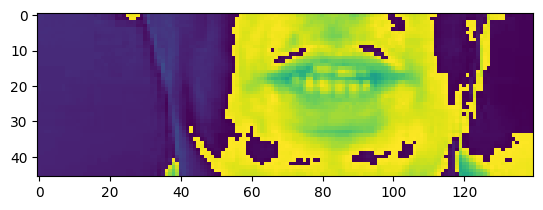

In [18]:
plt.imshow(frames[40])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.4149188 ],
          [1.4149188 ],
          [1.4149188 ],
          ...,
          [8.527754  ],
          [8.795442  ],
          [9.139611  ]],

         [[1.4149188 ],
          [1.4149188 ],
          [1.4149188 ],
          ...,
          [8.068861  ],
          [8.336549  ],
          [8.718959  ]],

         [[1.3384367 ],
          [1.3384367 ],
          [1.3384367 ],
          ...,
          [8.986647  ],
          [9.177852  ],
          [9.177852  ]],

         ...,

         [[0.95602626],
          [0.95602626],
          [0.95602626],
          ...,
          [9.674986  ],
          [9.674986  ],
          [9.674986  ]],

         [[0.91778517],
          [0.91778517],
          [0.91778517],
          ...,
          [9.6367445 ],
          [9.674986  ],
          [9.674986  ]],

         [[0.91778517],
          [0.91778517],
          [0.91778517],
          ...,
          [9.6367445 ],
          [9.674986  ],
          [9.674986  ]]],


        [[[1.3001

In [29]:
import numpy as np
import imageio

def convert_to_uint8(frames: np.ndarray) -> np.ndarray:
    """
    Convert frames from float32 to uint8 format.
    """
    min_val = frames.min()
    max_val = frames.max()
    frames = 255 * (frames - min_val) / (max_val - min_val)  # Normalize to 0-255
    return frames.astype(np.uint8)

def ensure_correct_shape(frames: np.ndarray) -> np.ndarray:
    """
    Ensure frames are in the format (height, width, channels).
    """
    if frames.ndim == 4:  # Format might be (frames, height, width, channels)
        if frames.shape[-1] == 1:  # Single channel, remove the channel dimension
            frames = np.squeeze(frames, axis=-1)
    return frames

# Convert frames to uint8
frames_uint8 = convert_to_uint8(val[0][0])

# Ensure frames have the correct shape
frames_correct_shape = ensure_correct_shape(frames_uint8)

# Save as GIF
imageio.mimsave('./animation.gif', frames_correct_shape, fps=10)


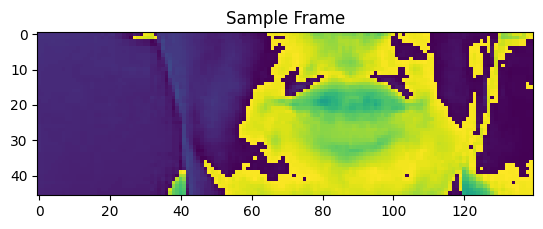

In [30]:
import matplotlib.pyplot as plt

# Ensure frames are in 3D format
def ensure_3d_frames(frames: np.ndarray) -> np.ndarray:
    """
    Ensure frames are in the format (height, width, channels).
    """
    if frames.ndim == 4 and frames.shape[-1] == 1:  # Grayscale
        frames = np.squeeze(frames, axis=-1)  # Remove single channel dimension
    return frames

# Adjust frames
frames_3d = ensure_3d_frames(frames_correct_shape)

# Visualize a specific frame
plt.imshow(frames_3d[35])
plt.title("Sample Frame")
plt.show()

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at z two please'>

# 3. Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
5*17*75

6375

In [35]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

model = Sequential()

# Convolutional Layers
model.add(Conv3D(128, 3, padding='same', input_shape=(75, 46, 140, 1)))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# TimeDistributed Layer
model.add(TimeDistributed(Flatten()))

# Calculate the exact number of features before reshaping
# Assuming TimeDistributed(Flatten()) produces shape (batch_size, time_steps, features)
# Replace 6375 with the actual number of features if different
model.add(Reshape((-1, 75)))  # Adjust as necessary based on actual output of Flatten

# LSTM Layers
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

# Dense Layer
model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax'))

model.summary()


c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6375, 75)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6375, 256)      │       208,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6375, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 6375, 256)      │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6375, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6375, 41)       │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,020,724 (7.71 MB)

 Trainable params: 2,020,724 (7.71 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'lllllooooooooooollllllllllllllllllllllllllllllllllllllllooooooollllllllllllllllllllllllll3333333333llllllllll33333333l?6llllll3333333llllllllll33333lllllllllll333333lllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllldlllllllllllllllllllllllllllllllllpllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpplllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllplllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppll

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lllllooooooooooollllllllllllllllllllllllllllllllllllllllooooooollllllllllllllllllllllllll3333333333llllllllll33333333l?6llllll3333333llllllllll33333lllllllllll333333lllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllldlllllllllllllllllllllllllllllllllpllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpplllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllplllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllpppll

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 6375, 41)

# 4. Setup Training Options and Train

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [45]:
# Define the checkpoint callback with correct file extension
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(test)

In [48]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100



InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_50 defined at (most recent call last):
  File "C:\Users\Mohit Chaudhary\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\Mohit Chaudhary\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Mohit Chaudhary\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Users\Mohit Chaudhary\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Users\Mohit Chaudhary\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code

  File "C:\Users\Mohit Chaudhary\AppData\Local\Temp\ipykernel_16744\3536403359.py", line 1, in <module>

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\models\sequential.py", line 212, in call

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\models\functional.py", line 560, in call

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\ops\numpy.py", line 4440, in reshape

  File "c:\Users\Mohit Chaudhary\Documents\GitHub\LipRead-Buddy\env\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_50}}]] [Op:__inference_one_step_on_iterator_125728]

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]